# Does collinearity affect fit?
## In the context of linear regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn.linear_model as lin
%matplotlib notebook

### Abstract:

Our assumption is that collinearity amongst the features, in the context of Linear Regression, does not affect the fit much. However it makes the coefficients of the fit tremendously uncertain and hence adversly affects the interpretability of the model. We will verify this assumption and then also provide a justification as to why is it so. The justification will contain a geometric insight into the reality behind.

### Verification of the assumption:

First comes the verification of the assumption. Towards this end we produce 100 simulated observations of two features - height (in feet) and weight (in kg). We generate a third feature - strength which is $2height + 3weight$. This is a perfect collinear relation of strength with height and weight. Our response is combatScore (score of an individual with a given height, weight and strength in combats). $combatScore = 2height + weight + \epsilon$ where $\epsilon$ is a random error.

With this sort of data we will first fit a linear regression model and record the coefficients and model fit score - $R^2$ score. Then we just shuffle the observations i.e., say $1^{st}$ observation becomes ${10}^{th}$ and so forth. We will fit linear regression again and record the coefficients and fit score for this shuffled dataset.

Comparing the two will verify our assumption.

In [12]:
# A function to streamline the above approach
def normalAndShuffled(data):
    '''
    Takes a data set with the assumption that the last column is response and
    rest are all features. Linear regression is run twice - once on the data itself
    and once on its shuffled version. The results of both runs are recorded
    and returned as a dataframe.
    '''
    df = pd.DataFrame(columns=['Order of observations', *(data.columns[:-1]),'Fit score'])
    linrgr = lin.LinearRegression()
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    linrgr.fit(X,y)
    df.loc[len(df)] = ['Normal', *(linrgr.coef_), linrgr.score(X,y)]
    
    datashuffled = data.sample(frac=1,random_state=6)
    linrgr = lin.LinearRegression()
    X = datashuffled.iloc[:,:-1]
    y = datashuffled.iloc[:,-1]
    linrgr.fit(X,y)
    df.loc[len(df)] = ['Shuffled', *(linrgr.coef_), linrgr.score(X,y)]
    
    return df

In [3]:
heights = np.random.uniform(5.0,7.0,100)
weights = np.random.uniform(45.0,80.0,100)
strength = 2*heights + 3*weights
combatscore = 2*heights + weights + np.random.uniform(0.0,10.0,100)

data = pd.DataFrame(data=np.array([heights,weights,strength,combatscore]).T, columns=['height','weight','strength','combatscore'])
data

,height,weight,strength,combatscore
0,6.225901,45.766333,149.750800,60.034969
1,6.013151,48.870063,158.636490,64.665480
2,6.155447,65.244368,208.043996,78.652111
3,5.760203,77.998437,245.515717,90.832437
4,5.107879,63.211054,199.848919,77.787016
...,...,...,...,...
95,5.031565,73.335634,230.070031,92.827731
96,5.420751,47.997719,154.834659,65.096767
97,5.291968,65.213674,206.224958,81.363866
98,5.845136,48.019403,155.748482,62.560030


In [4]:
normalAndShuffled(data)

,Order of observations,height,weight,strength,Fit score
0,Normal,-1.637795e+12,-2.456692e+12,8.188974e+11,0.924293
1,Shuffled,8.550921e-01,-4.129198e-01,4.714248e-01,0.924264


**We clearly see a drastic difference between the coefficients although the fit score is nearly the same.** This highlights a very genuine issue. Shuffling the observations is not even a change in the training data. Even at that point this strange deviation of the coefficient values is noticed. However what is strange is that the model fit is barely affected by this. **What is so special about "the calculations involved in the model fit" that it passes unscathed through this collinearity while the coefficients do not?** 

### A geometrical interpretation

We will attempt to see what the coefficients are and what does the model fit score denote via a vectorial treatment. The columns of height, weight, strength and combatscore are 100-dimensional vectors. What we are essentially trying to do is express combatscore as a linear combination of the vectors, as good as possible. To demonstrate that better I will use some vector plots. Let's create those plots first.

In [5]:
def plotvectors(a,b,c,u):
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    x_cord = lambda vectors: [vector[0] for vector in vectors]
    y_cord = lambda vectors: [vector[1] for vector in vectors]
    z_cord = lambda vectors: [vector[2] for vector in vectors]

    vectors = [a,b,c,u]
    ax.quiver(0,0,0,x_cord(vectors),y_cord(vectors),z_cord(vectors),colors=['b','g','r','k'])
    ax.set_xlim(-1,5)
    ax.set_ylim(-1,5)
    ax.set_zlim(-1,5)
    ax.text(*(a+0.01),'a')
    ax.text(*(b+0.01),'b')
    ax.text(*(c+0.01),'c')
    ax.text(*(u+0.01),'u')

    x = np.linspace(-2,2,50)
    P,Q = np.meshgrid(x,x)
    X = a[0]*P + b[0]*Q
    Y = a[1]*P + b[1]*Q
    Z = a[2]*P + b[2]*Q
    ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,alpha=0.3)

Let's say $a = (3,0,0)$, $b = (0,3,0)$ and $c = 0.7a+0.8b$. So $c$ lies in the plane swept by $a$ and $b$. Now $u = a + b + \epsilon$ where $\epsilon$ is a random error. Our aim is to express $u$ as good as possible in terms of $a$, $b$ and $c$.

In [6]:
a = np.array([3,0,0])
b = np.array([0,3,0])
epsilon = np.array([0,0,1.5])

# c collinear with a and b
c = 0.7*a + 0.8*b 
# Generate u = a+b+epsilon

u = a + b + epsilon

<IPython.core.display.Javascript object>


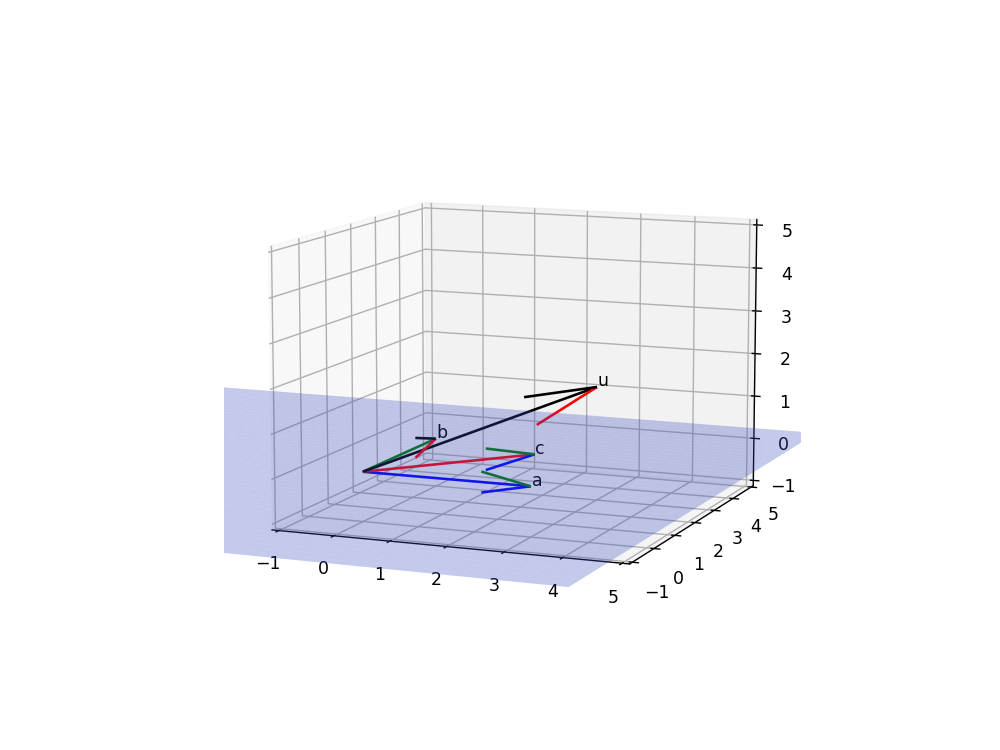

In [7]:
plotvectors(a,b,c,u)

Now the best approximation of $u$ in terms of $a$, $b$ and $c$ will be when the perpendicular projection of $u$ on the plane, say $u_p$, is expressed in terms of $a$, $b$ and $c$. This expression can actually be many possible ways because we need only two such vectors $a$ and $b$ while in this case we have three - $a$, $b$ and $c$. This precisely is the problem that collinearity produces - the coefficients to express $u_p$ becomes uncertain, not definite.

How is the model fit represented in this context? The closer $u$ is to its projection $u_p$ the better the fit. So it is the perpendicular distance of $u$ from the plane that gives a measure of the amount by which the fit falls short. Does this amount change when the vector elements are shuffled?

We change $a$ from $(3,0,0) --> (0,3,0)$, $b$ from $(0,3,0) --> (0,0,3)$, $\epsilon$ from $(0,0,1.5) --> (1.5,0,0)$ and do the above plot again. The expressions for $c$ and $u$ remain unchanged. The real world interpretations of $a$, $b$, $c$ and $u$ thus remain the same post this shuffling.

In [8]:
a = np.array([0,3,0])
b = np.array([0,0,3])
epsilon = np.array([1.5,0,0])

# c collinear with a and b
c = 0.7*a + 0.8*b 
# Generate u = a+b+epsilon

u = a + b + epsilon

<IPython.core.display.Javascript object>


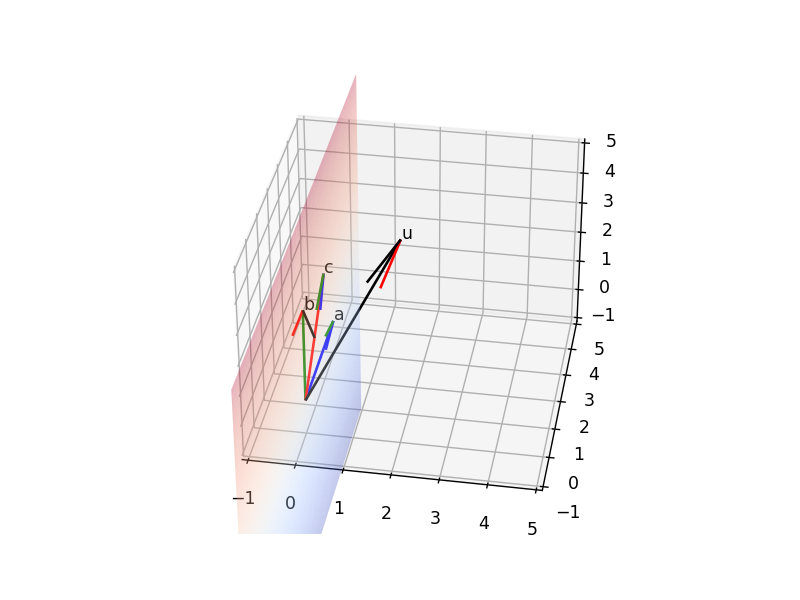

In [9]:
plotvectors(a,b,c,u)

The vectors might have changed allignment but the perpendicular distance of $u$ from the plane is the same as before. I am not attempting any analytical proof here because the figure itself seems too convincing. Hence the fit is the same. However when Linear regression runs, element-wise entries of the vector get involved in the calculations. Changing their order can drastically change the expression of $u_p$ in terms of $a$, $b$ and $c$.

Had there been only two vectors $a$ and $b$, this arbitrariness would not have entered. To demonstrate that, we will now drop the column of strength from our dataset and re-run the normal and shuffle mode fits.

In [10]:
data.drop(columns=['strength'], inplace=True)
data

,height,weight,combatscore
0,6.225901,45.766333,60.034969
1,6.013151,48.870063,64.665480
2,6.155447,65.244368,78.652111
3,5.760203,77.998437,90.832437
4,5.107879,63.211054,77.787016
...,...,...,...
95,5.031565,73.335634,92.827731
96,5.420751,47.997719,65.096767
97,5.291968,65.213674,81.363866
98,5.845136,48.019403,62.560030


In [11]:
normalAndShuffled(data)

,Order of observations,height,weight,Fit score
0,Normal,1.797942,1.001355,0.924264
1,Shuffled,1.797942,1.001355,0.924264


Now the coefficients are the same in both cases.

### Conclusion

<b>So, in the context of Linear Regression, the fit is not affected by collinearity but model coefficients' uncertainty, and hence interpretability, is.

The same cannot be guaranteed for other models though, as I am not pretty sure if the vectorial treatment can be carried forward to them as well.</b>